In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import h5py
import PIL

In [2]:
#from data.convert_distance_to_depth import * 
import sys  
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/../")

sys.path.append(module_path+"/../../")

#sys.path.insert(0, '../../data/')

#from loaddata import *

from data.convert_distance_to_depth import *

In [3]:
#test_dataframe = pd.read_csv("../../data/downloads/image_file_test.csv")
dataframe = pd.read_csv("../../data/downloads/image_files.csv")
number_of_samples = dataframe.shape[0];
print(number_of_samples)

FileNotFoundError: [Errno 2] No such file or directory: '../../data/downloads/image_files.csv'

In [4]:
############################ careful ####################### 
import csv 
test_file_name = open(os.path.join("../../data/downloads/", "image_file_visualize.csv"), "w", newline="")
writer = csv.writer(test_file_name)

writer.writerow(["Depth", "Segmentation", "ToneMapped"])
 
for i in range(0, number_of_samples, 100):
    #print(dataframe.iloc[i])
    writer.writerow(dataframe.iloc[i].to_list())

NameError: name 'number_of_samples' is not defined

In [3]:
csv_file_name = "../../data/downloads/train_data.csv"

In [4]:
from data.downloader import test_train_split
#test_train_split(csv_file_name)

train_dataset = pd.read_csv("../../data/downloads/train_data.csv")
test_dataset = pd.read_csv("../../data/downloads/test_data.csv")

print(train_dataset.shape[0])

print(list(train_dataset.columns.values))
print(train_dataset.shape[1])

print(test_dataset.shape[0])


108
['Depth', 'Segmentation', 'ToneMapped']
3
10


In [5]:
test_dataframe = pd.read_csv(csv_file_name)
number_of_samples = test_dataframe.shape[0];
print(number_of_samples)

path_prefix = os.environ['THREED_VISION_ABSOLUTE_DOWNLOAD_PATH']

108


In [6]:
test_depth_image_name = path_prefix + test_dataframe["Depth"][0] 
test_depth_image = h5py.File(test_depth_image_name, "r", )["dataset"][()]

print(test_depth_image.max(axis=(0,1)))
print(test_depth_image.min(axis=(0,1)))

#test_color_image_name = test_dataframe["RGB"][0]
#test_color_image = h5py.File(test_color_image_name, "r")["dataset"][()] 

test_toned_color_image_name = path_prefix + test_dataframe["ToneMapped"][0]
test_toned_color_image = PIL.Image.open(test_toned_color_image_name, "r")

print(np.array(test_toned_color_image).shape)

test_segmentation_image_name = path_prefix + test_dataframe["Segmentation"][0]
test_segmentation = h5py.File(test_segmentation_image_name, "r",)["dataset"][()]
test_segmentation = PIL.Image.fromarray(test_segmentation)  

print(test_segmentation.min())
print(test_segmentation.max())

5.785
1.082
(768, 1024, 3)


AttributeError: min

In [74]:
class ConvertSemanticLabelsToRGB(object):

    def __init__(self):
        self.mappings = pd.read_csv("../../data/semantic_label_descs.csv",usecols=["semantic_color_r", "semantic_color_g", "semantic_color_b"])

    def __call__(self, image):
        return self.convert_semantic_label_to_rgb(image)

    def convert_semantic_label_to_rgb(self, image):
        print(image.size)
        rgb_image = np.empty(shape=(image.size[1], image.size[0], 3), dtype=np.uint8)
        image = np.asarray(image, )
        print(rgb_image.shape)
        #mask = image[image == -1]
        print(image.shape)
        rgb_image[image == -1, :] = [255, 255, 255]  # white
        for label in range(1, 41):
            
            #print(rgb_image[image == label].any())
            rgb_image[image == label, :] = self.mappings.iloc[label - 1]

            #print(self.mappings.iloc[label - 1])

            if(image[image == label].any()):
                print(rgb_image.max())
                print((rgb_image.min()))

        return Image.fromarray(rgb_image) 

In [75]:
convert_semantic_labels_to_rgb = ConvertSemanticLabelsToRGB()

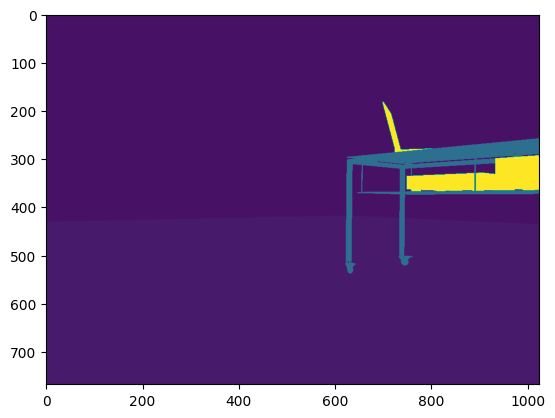

In [8]:
plt.imshow(np.array(test_segmentation))

In [76]:
rgb_image = convert_semantic_labels_to_rgb.convert_semantic_label_to_rgb(test_segmentation)

rgb_image_numpy = np.array(rgb_image)


(1024, 768)
(768, 1024, 3)
(768, 1024)
255
0
255
0
255
0
255
85


255
85
uint8


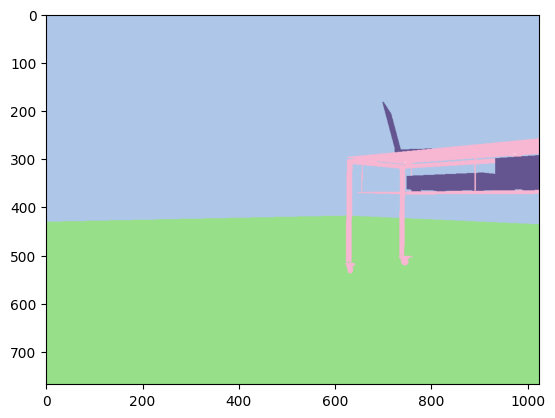

In [77]:
print(rgb_image_numpy.max())
print(rgb_image_numpy.min())
print(rgb_image_numpy.dtype)
plt.imshow(rgb_image_numpy)

(1024, 768)
(96, 255)


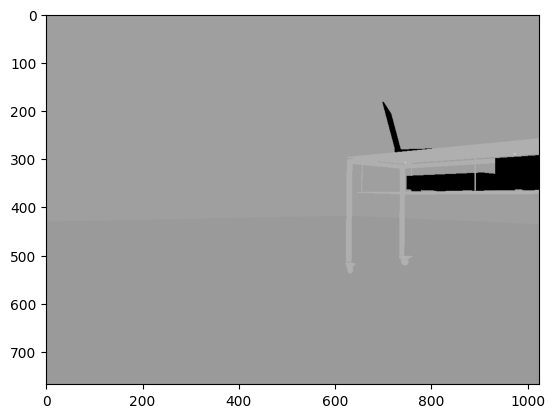

In [85]:
from nyu_transform  import Grayscale
grayscale_conversion = Grayscale()
grayscale_image = grayscale_conversion(rgb_image)

print(grayscale_image.size)
print(grayscale_image.getextrema())
#print(grayscale_image.min)
#print(grayscale_image.dtype)
plt.imshow(grayscale_image, cmap='gray')

In [30]:
import sobel

class CannyEdgeDetection(object):
    """"
    extract the edges of the segmentation masks using canny edge detection
    """

    def __init__(self, threshold):
        self.threshold = threshold
        if (torch.cuda.is_available()):
            self.get_edge = sobel.Sobel(3).cuda()
        else:
            self.get_edge = sobel.Sobel(3)

    def __call__(self, image):
        image = self.edge_detection(image)
        return image

    def edge_detection(self, image):
        edge_xy = self.get_edge(image)[0, : ,: ,:] #no batch
        print("get edge did not work")
        edge_sobel = torch.pow(edge_xy[0, :, :], 2) + \
                     torch.pow(edge_xy[1, :, :], 2)
        edge_sobel = torch.sqrt(edge_sobel)

        edge_sobel = (edge_sobel > self.threshold)

        return edge_sobel

In [31]:
from nyu_transform import *
from torchvision import transforms 
transform_segmentation_mask = transforms.Compose(
            [Scale(240, Image.NEAREST), CenterCrop([304, 228], [304, 228]),
             ToTensor()])


In [32]:
rgb_image_transformed = transform_segmentation_mask(Image.fromarray(rgb_image))

In [38]:
canny_edge_detection = CannyEdgeDetection(0.5)

edge_of_segmentation_mask = canny_edge_detection(rgb_image_transformed)

print(edge_of_segmentation_mask.min())
print(edge_of_segmentation_mask.max())

<class 'int'>
get edge did not work
tensor(False)
tensor(True)


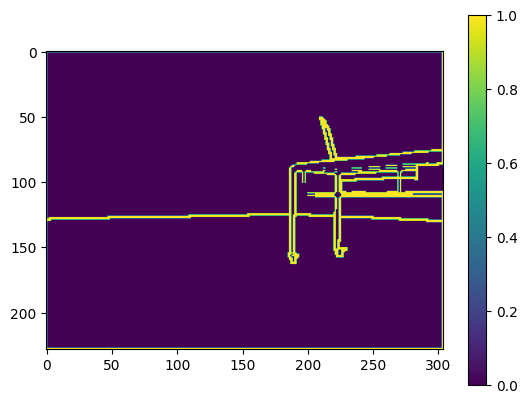

In [36]:
display_tensor_data(edge_of_segmentation_mask.unsqueeze(0))

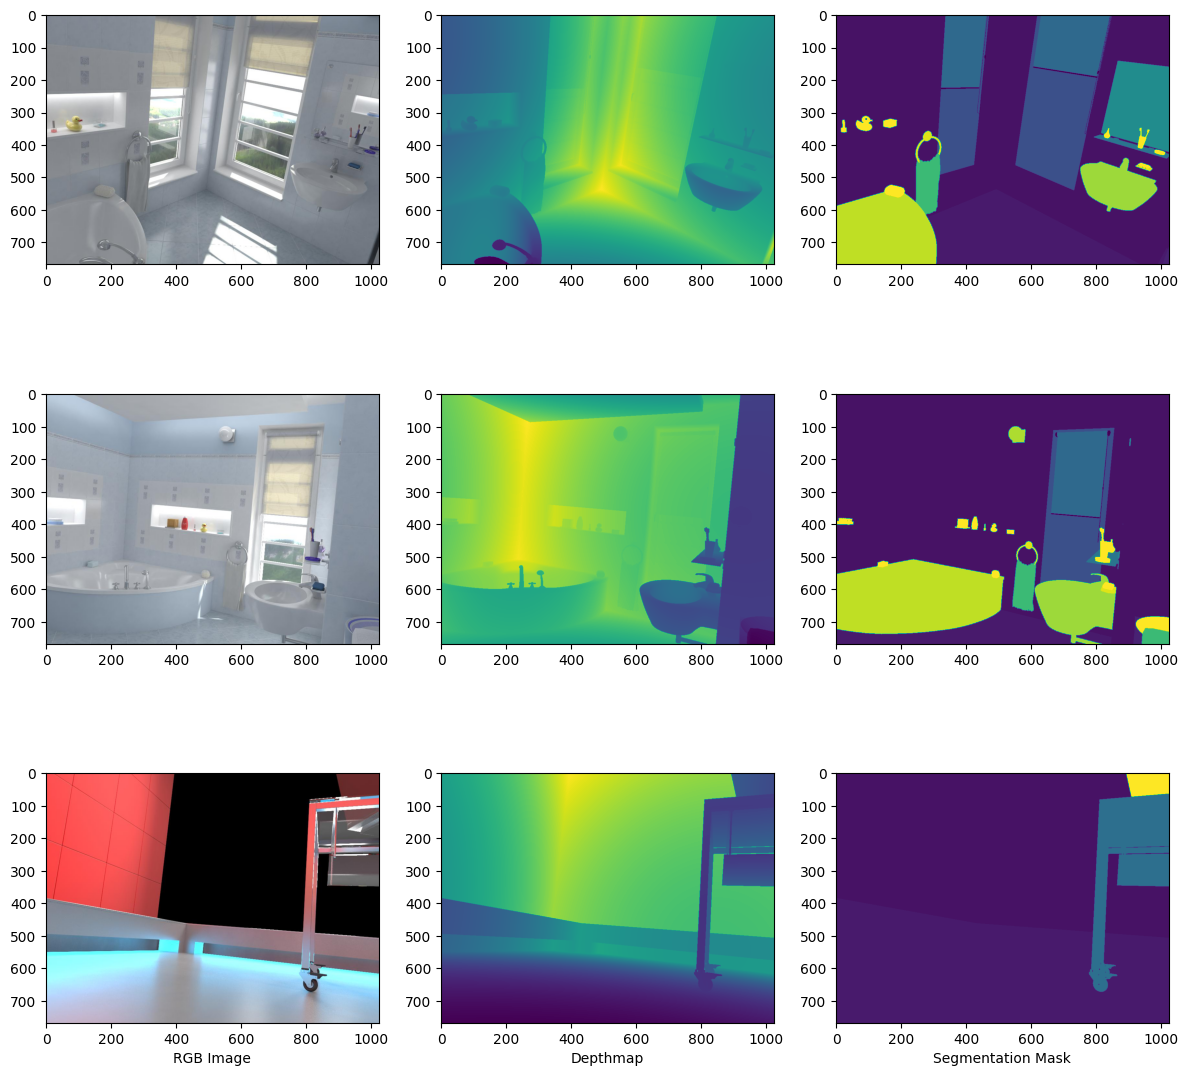

In [ ]:
def get_image(dataframe, index):
    image_triplets = []
    for keyword in ["ToneMapped", "Depth", "Segmentation"]:
        image_name = dataframe[keyword][index]
        if ".hdf5" in image_name:
            image = h5py.File(image_name, "r", )["dataset"][()]
            image_triplets.append(image)
        else: 
            image = Image.open(image_name, "r") 
            image_triplets.append(image) 
    return image_triplets 
    

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
for index in range(0,axs.shape[0]):
    image_triplets = get_image(test_dataframe, index)
    axs[index,0].imshow(image_triplets[0])
    axs[index, 0].set_aspect("equal")
    axs[index,1].imshow(image_triplets[1])
    axs[index, 1].set_aspect("equal")
    axs[index,2].imshow(image_triplets[2])
    axs[index, 2].set_aspect("equal")


    
axs[-1,0].set_xlabel("RGB Image")
axs[-1,1].set_xlabel("Depthmap")
axs[-1,2].set_xlabel("Segmentation Mask")
fig.tight_layout()
#fig.subplots_adjust(wspace=0.2, hspace=0)
"""
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
"""
plt.show()
fig.savefig("hypersim.png", bbox_inches='tight')

In [6]:
def display_image(data, remapping=None):
    np_data = np.array(data)
    if remapping != None: 
        np_data = remapping(np_data)
    fig, (ax) = plt.subplots(1)
    pcm = ax.imshow(np_data)
    fig.colorbar(pcm, ax=ax)    
    plt.show()
    

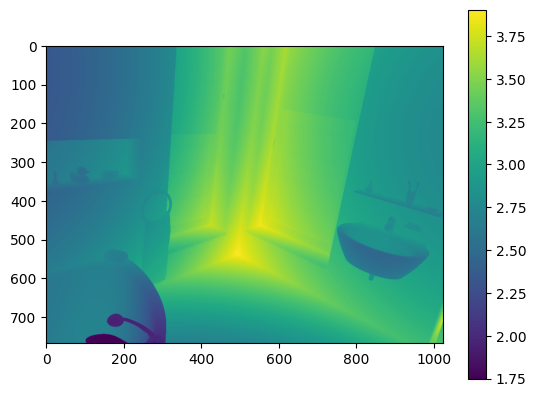

In [ ]:
### distance to camera center
display_image(test_depth_image)

In [7]:
#### planar depth values
from data.convert_distance_to_depth import * 
    
display_image(test_depth_image, convert_distance_to_depth)

NameError: name 'display_image' is not defined

In [ ]:
def remap_data(np_array,wanted_max=255):
    return (np_array/np_array.max(axis=(0,1))*wanted_max).astype(np.uint8)

(768, 1024, 3)
(240, 320, 3)


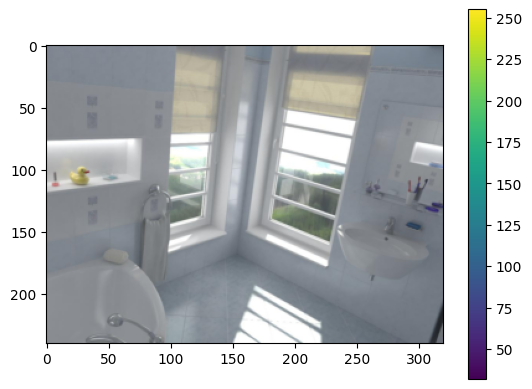

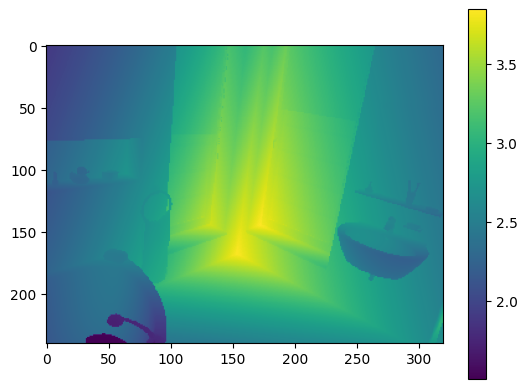

In [ ]:
### check data transformation ####### 
test_dataset = depthDataset(csv_file=csv_file_name,
                                       transform=transforms.Compose([
                                           Scale(240)]))

test_sample = test_dataset.__getitem__(0); 

print(np.array(test_toned_color_image).shape)
print(np.array(test_sample["image"]).shape)

display_image(test_sample["image"])

display_image(test_sample["depth"])


(768, 1024, 3)
(228, 304, 3)


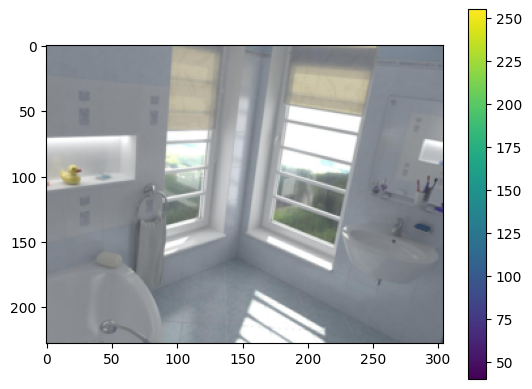

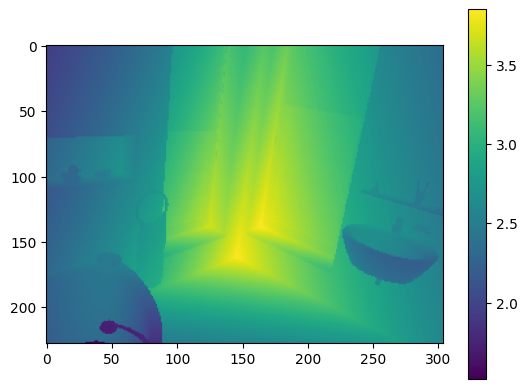

In [ ]:
### check data transformation ####### 
test_dataset = depthDataset(csv_file=csv_file_name,
                                       transform=transforms.Compose([
                                           Scale(240), CenterCrop([304, 228], [304, 228])]))

test_sample = test_dataset.__getitem__(0); 

print(np.array(test_toned_color_image).shape)
print(np.array(test_sample["image"]).shape)

display_image(test_sample["image"])

display_image(test_sample["depth"])


In [21]:
def display_tensor_data(tensor, remap=None):
    if remap != None:
        tensor = remap(tensor)
    fig, (ax) = plt.subplots(1)
    pcm = ax.imshow(tensor.permute(1,2,0))
    fig.colorbar(pcm, ax=ax) #ticks=[-1, 0, 1]) 
    plt.show()

torch.Size([3, 228, 304])


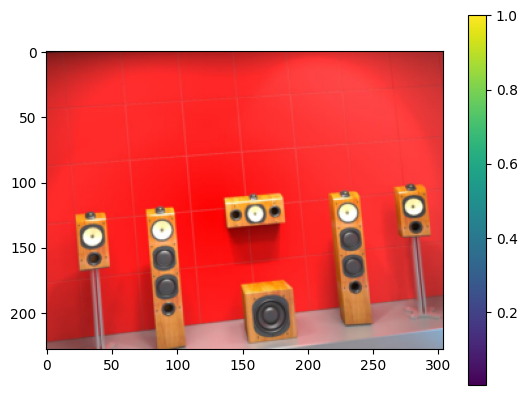

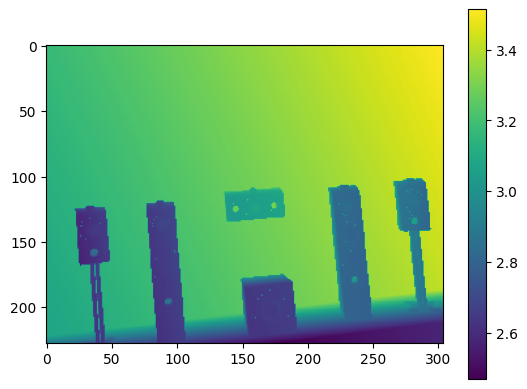

In [8]:
#### check data transformation ####### 

mean, std = get_dataset_stats(csv_filename=csv_file_name)

test_dataset = depthDataset(csv_file=csv_file_name,
                                       transform=transforms.Compose([
                                           Scale(240), CenterCrop([304, 228], [304, 228]), ToTensor(is_test=True)]))

test_sample = test_dataset.__getitem__(45); 

print(test_sample["image"].shape)

display_tensor_data(test_sample["image"])

display_tensor_data(test_sample["depth"])

In [16]:
import loaddata
# train_loader = loaddata.getTrainingData(2)

mean, std = get_dataset_stats(csv_filename=csv_file_name)

train_dataset = depthDataset(csv_file=csv_file_name,
                                       transform=transforms.Compose([
                                           Scale(240), CenterCrop([304, 228], [304, 228]), ToTensor(is_test=False), Normalize(mean, std) ]))

train_loader = DataLoader(train_dataset, 1,
                                     shuffle=False, num_workers=4, pin_memory=False)
training_data = loaddata.getTrainingData(1)

In [17]:
for sample_batched, sample_batched2 in zip(train_loader,training_data):
    image, depth = sample_batched['image'], sample_batched['depth']
    image2, depth2 = sample_batched2['image'], sample_batched2['depth']

    
    # display_tensor_data(image)
    if  depth2.isnan().sum() > 20:
        display_tensor_data(image[0,:,:,:])
        print(torch.where(image.isnan()))
        
        display_tensor_data(image2[0,:,:,:])
        print(torch.where(image2.isnan()))
        
        
        display_tensor_data(depth[0,:,:,:])
        print(torch.where(depth.isnan()))
        
        display_tensor_data(depth2[0,:,:,:])
        print(torch.where(depth2.isnan()))
    
    

TypeError: 'DataLoader' object is not subscriptable

float16
are there already depth values in raw data:  True
ai_001_002/images/scene_cam_00_geometry_hdf5/frame.0095.depth_meters.hdf5


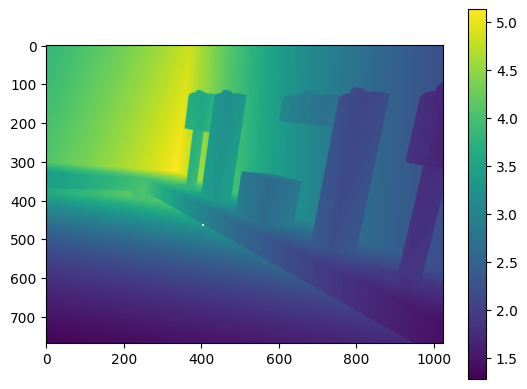

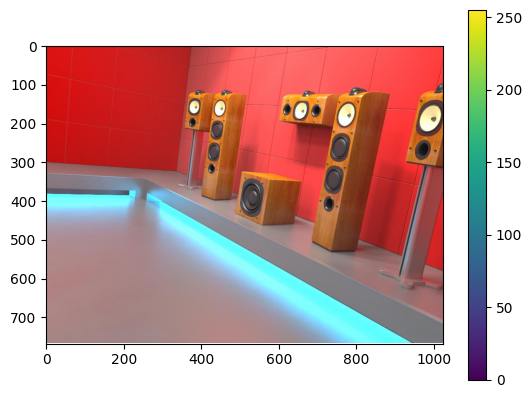

68
(array([463]), array([405]))
float16
are there already depth values in raw data:  True
ai_001_002/images/scene_cam_02_geometry_hdf5/frame.0079.depth_meters.hdf5


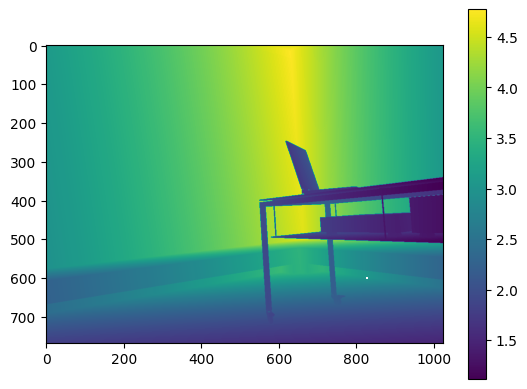

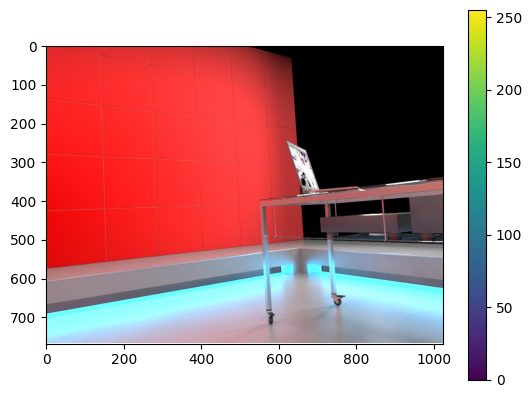

73
(array([599]), array([828]))
float16
are there already depth values in raw data:  True
ai_001_002/images/scene_cam_03_geometry_hdf5/frame.0090.depth_meters.hdf5


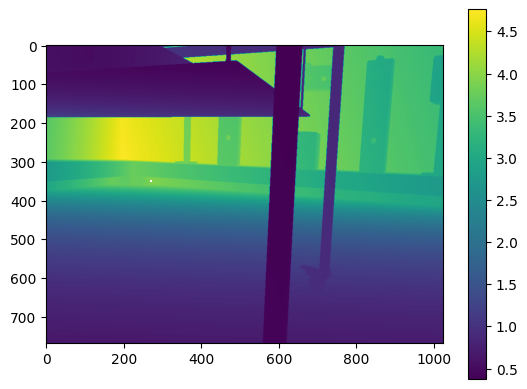

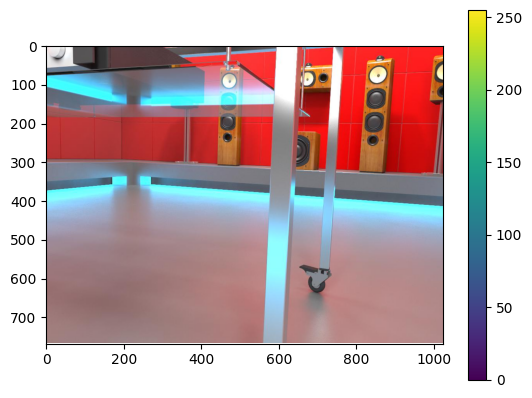

82
(array([349]), array([270]))
float16
are there already depth values in raw data:  True
ai_001_002/images/scene_cam_01_geometry_hdf5/frame.0090.depth_meters.hdf5


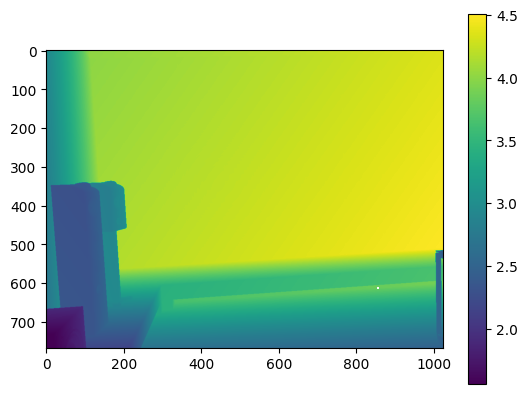

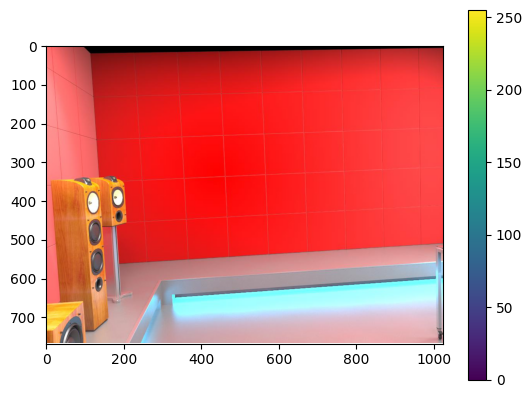

83
(array([613]), array([856]))
float16
are there already depth values in raw data:  True
ai_001_002/images/scene_cam_01_geometry_hdf5/frame.0072.depth_meters.hdf5


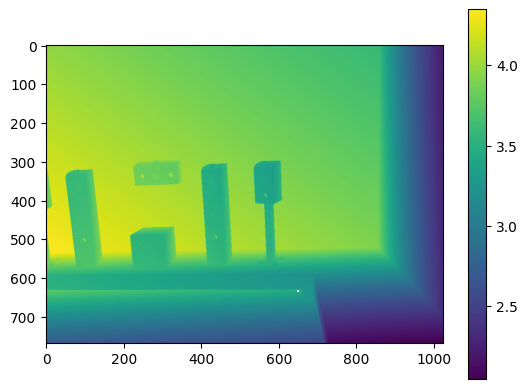

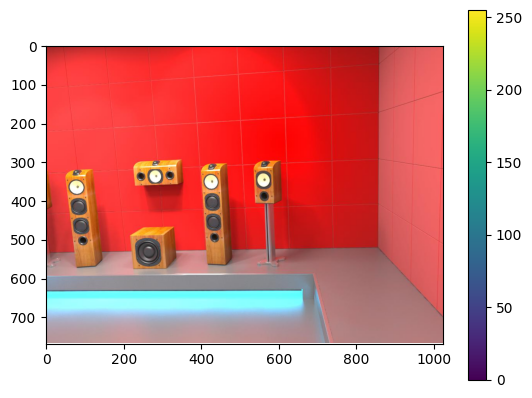

95
(array([633]), array([650]))
float16
are there already depth values in raw data:  True
ai_001_002/images/scene_cam_01_geometry_hdf5/frame.0073.depth_meters.hdf5


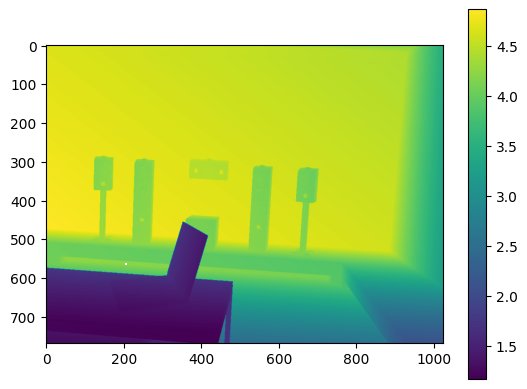

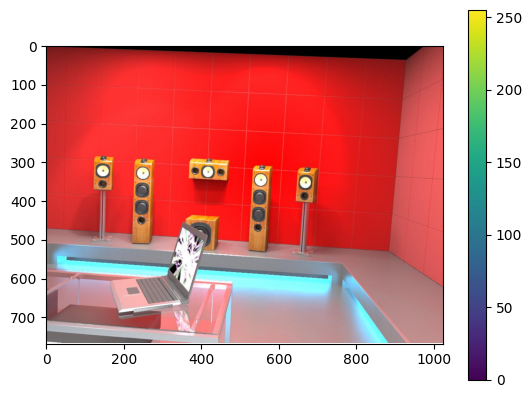

99
(array([565]), array([207]))
float16
are there already depth values in raw data:  True
ai_001_002/images/scene_cam_01_geometry_hdf5/frame.0071.depth_meters.hdf5


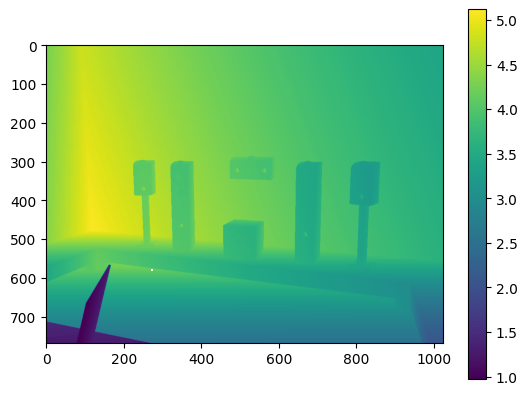

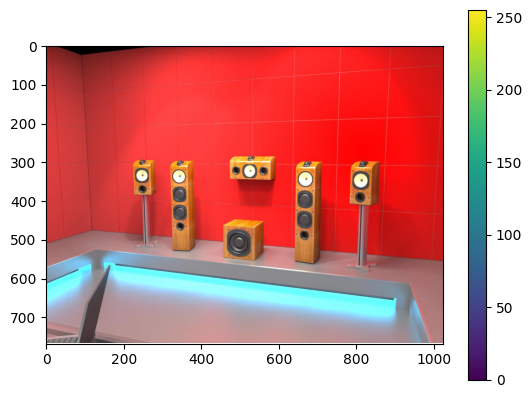

102
(array([579]), array([272]))
float16
are there already depth values in raw data:  True
ai_001_002/images/scene_cam_01_geometry_hdf5/frame.0046.depth_meters.hdf5


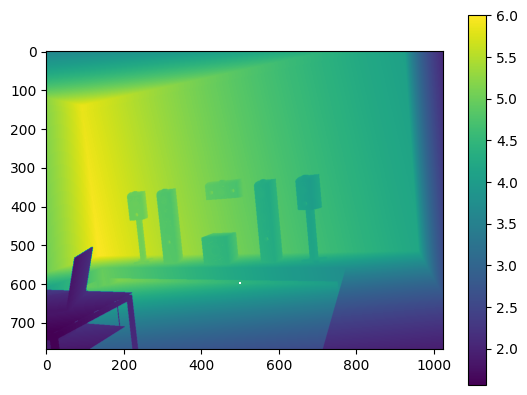

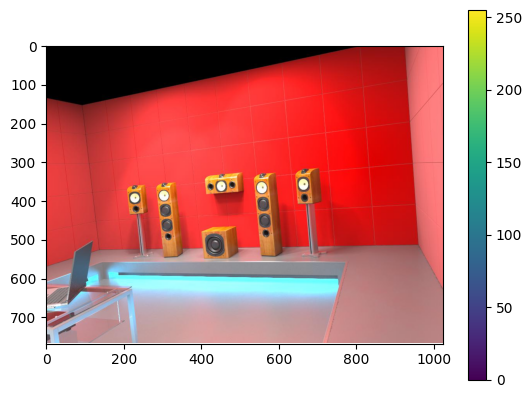

106
(array([598]), array([501]))
float16
are there already depth values in raw data:  True
ai_001_002/images/scene_cam_00_geometry_hdf5/frame.0030.depth_meters.hdf5


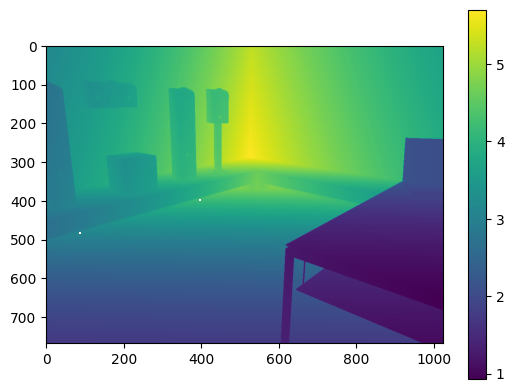

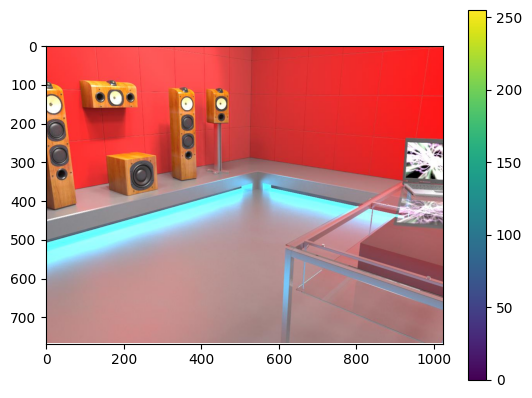

107
(array([398, 485]), array([398,  87]))
float16
are there already depth values in raw data:  True
ai_001_002/images/scene_cam_01_geometry_hdf5/frame.0064.depth_meters.hdf5


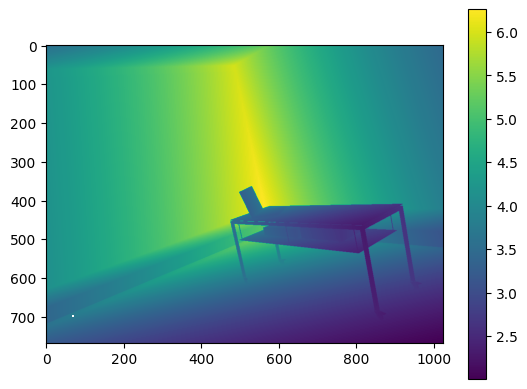

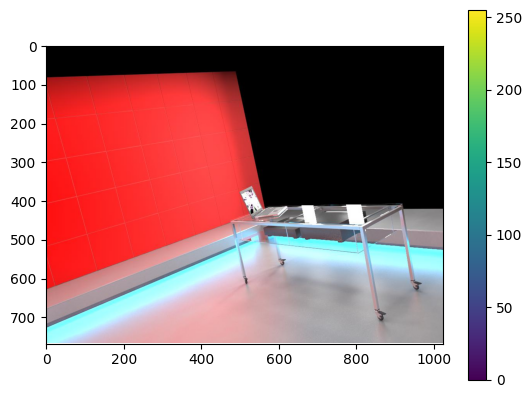

114
(array([699]), array([70]))
float16
are there already depth values in raw data:  True
ai_001_002/images/scene_cam_00_geometry_hdf5/frame.0050.depth_meters.hdf5


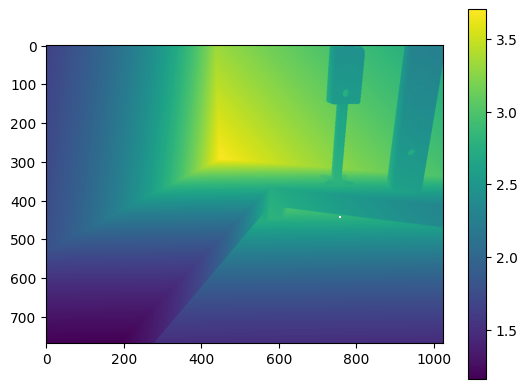

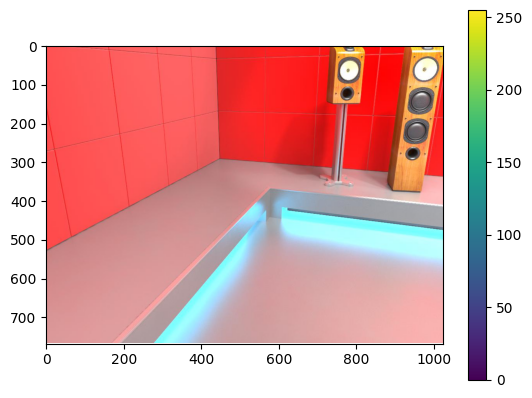

123
(array([443]), array([757]))
float16
are there already depth values in raw data:  True
ai_001_002/images/scene_cam_02_geometry_hdf5/frame.0017.depth_meters.hdf5


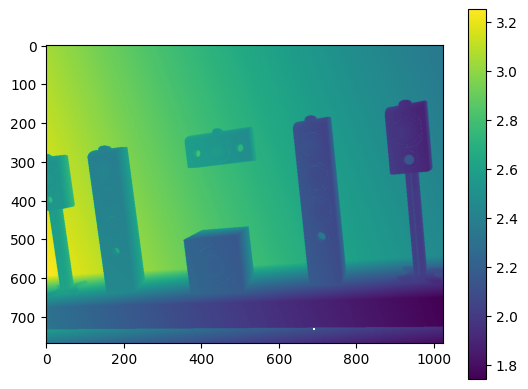

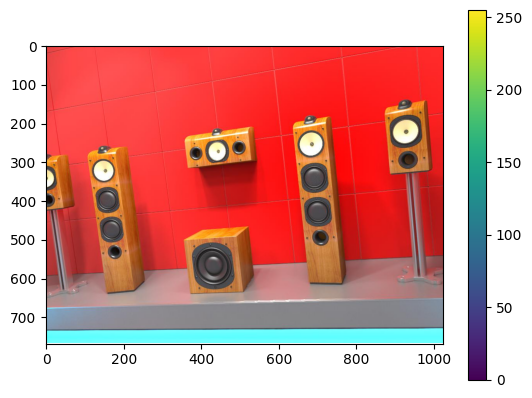

140
(array([732]), array([692]))


In [14]:
import loaddata
# train_loader = loaddata.getTrainingData(2)
train_dataset = depthDataset(csv_file=csv_file_name,
                                       transform=None)
                                           
for file in range(0,train_dataset.frame.shape[0]):
    test_sample = train_dataset.__getitem__(file)
    if np.isnan(test_sample["depth"]).any():
        print(train_dataset.frame["Depth"][file])
        display_image(test_sample["depth"])
        display_image(test_sample["image"])
        print(file)
        print(np.where(np.isnan(test_sample["depth"])==1))
    

In [23]:
    def normalize(tensor, mean, std):
        """Normalize a tensor image with mean and standard deviation.
        See ``Normalize`` for more details.
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
            mean (sequence): Sequence of means for R, G, B channels respecitvely.
            std (sequence): Sequence of standard deviations for R, G, B channels
                respecitvely.
        Returns:
            Tensor: Normalized image.
        """

        # TODO: make efficient
        for t, m, s in zip(tensor, mean, std):
            print(t.min())
            print(t.max())
            t.sub_(m).div_(s)
            print(t.min())
            print(t.max())
            
            
        return tensor

In [41]:
from data.get_image_stats import get_dataset_stats
mean, std = get_dataset_stats(csv_file_name)
def denormalize(image):
    for channel in range(0, image.shape[0]):
        image[channel,:,:].mul_(std[channel]).add_(mean[channel])
    return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(40, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.1569)
tensor(1.)
torch.float32
tensor(0.1569)
tensor(1.)
tensor(-2.3538)
tensor(1.6938)
tensor(0.1804)
tensor(1.)
tensor(-1.2619)
tensor(2.0671)
tensor(0.1843)
tensor(1.)
tensor(-1.1690)
tensor(2.0499)
torch.Size([3, 228, 304])


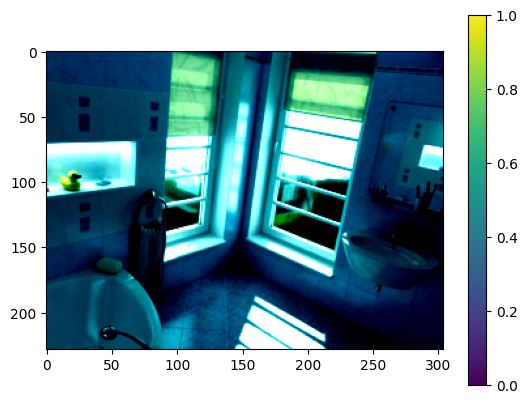

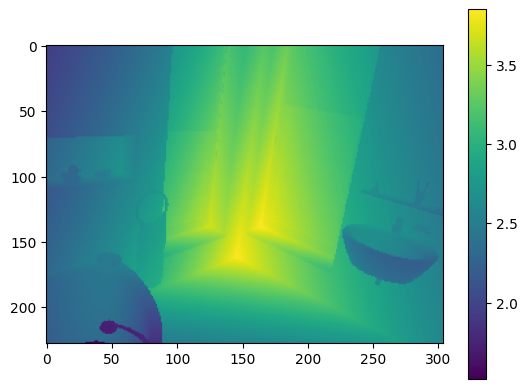

In [24]:
### check data transformation ####### 

mean, std = get_dataset_stats(csv_filename=csv_file_name)

test_dataset = depthDataset(csv_file=csv_file_name,
                                       transform=transforms.Compose([
                                           Scale(240), CenterCrop([304, 228], [304, 228]), ToTensor(is_test=True)]))

test_sample = test_dataset.__getitem__(0)

print(test_sample["image"].dtype)

normalized_color_image = normalize(test_sample["image"], mean, std)

print(test_sample["image"].shape)

display_tensor_data(normalized_color_image)

display_tensor_data(test_sample["depth"])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.64255929 0.50137264 0.49386166]
[0.22883341 0.24708676 0.25379886]


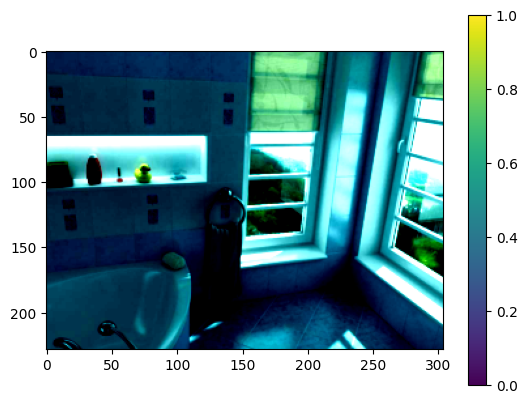

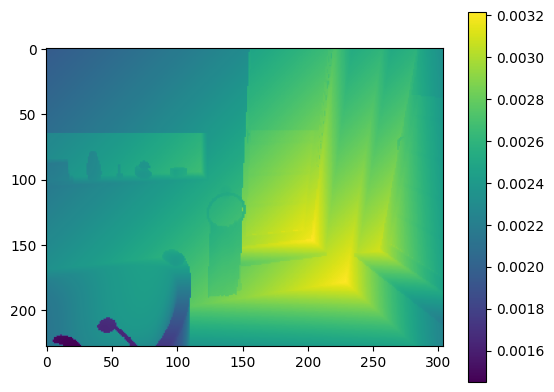

In [18]:
### check data transformation ####### 

mean, std = get_dataset_stats(csv_filename=csv_file_name)

print(mean)

print(std)

test_dataset = depthDataset(csv_file=csv_file_name,
                                       transform=transforms.Compose([
                                           Scale(240), CenterCrop([304, 228], [304, 228]), ToTensor(is_test=True), Normalize(mean, std)]))

test_sample = test_dataset.__getitem__(0)

display_tensor_data(test_sample["image"])

display_tensor_data(test_sample["depth"])

In [29]:
########## check edge detection ############# 
from test import *

torch.Size([1, 1, 228, 304])


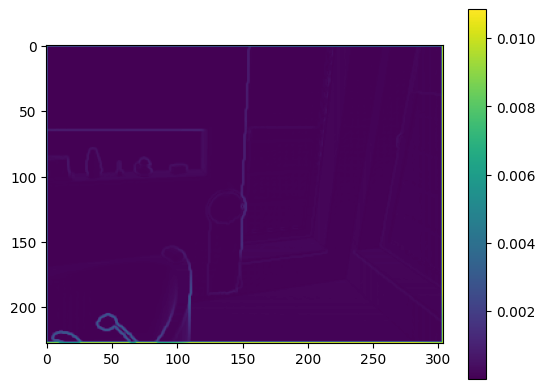

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


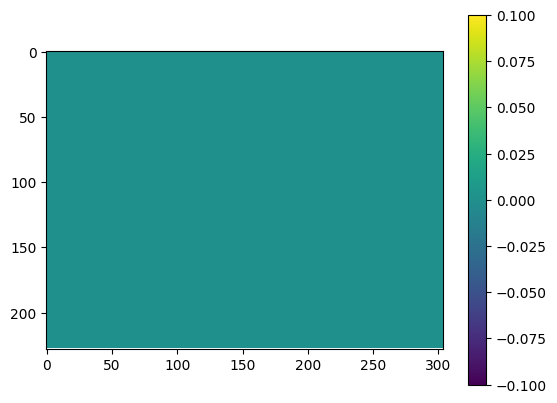

In [20]:
print(test_sample["depth"][None,:].shape) 
if(torch.cuda.is_available()):
    depth_edge = edge_detection(test_sample["depth"][None, :].cuda()) #additional dimension due to batch 
    display_tensor_data(depth_edge.cpu())
    
else:
    depth_edge = edge_detection(test_sample["depth"][None, :]) 
    display_tensor_data(depth_edge)



thre = 0.25
edge_valid = (depth_edge > thre)

print(edge_valid.min())
print(edge_valid.max())

display_tensor_data(edge_valid.cpu())

In [26]:
torch.cuda.is_available = lambda : False

In [30]:
model = define_model(is_resnet=False, is_densenet=False, is_senet=True)
if(torch.cuda.is_available()):
    model = torch.nn.DataParallel(model).cuda()
    model.load_state_dict(torch.load('./pretrained_model/model_senet', map_location=torch.device('cpu')))
else:
    model = torch.nn.DataParallel(model)
    model.load_state_dict(torch.load('./pretrained_model/model_senet', map_location=torch.device('cpu')))
    


In [31]:
def test_sample(model, test_loader): 
    model.eval()
    depth_results = []
    for i, sample_batched in enumerate(test_loader):
        torch.cuda.empty_cache()
        
        image, depth = sample_batched['image'], sample_batched['depth']
        if(torch.cuda.is_available()):
            depth = depth.cuda(non_blocking=True) #
            image = image.cuda()
        image = torch.autograd.Variable(image, requires_grad=False)
        depth = torch.autograd.Variable(depth, requires_grad=False)
        output = model(image)
        output = torch.nn.functional.interpolate(output, size=[depth.size(2),depth.size(3)], mode='bilinear')
        #display_tensor_data(output[0,:].detach())
        #display_tensor_data(depth[0,:])
        #plt.imshow(output[0,:].permute(1, 2, 0).detach().numpy())
        #plt.show()
        depth_results.append(output)
        torch.cuda.empty_cache()
        
    return depth_results
    

In [32]:
###### network output ########### 
torch.cuda.empty_cache()
test_loader = loaddata.getTestingData(1, csv_file_name)
depth_results = test_sample(model, test_loader)



[0.64717275 0.49108199 0.48054518]
[0.20830748 0.2462041  0.25340463]
tensor(40, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.1569)
tensor(1.)
tensor(-2.3538)
tensor(2.0671)


/Users/alicemazzoleni/anaconda3/envs/3dVisionProject/lib/python3.9/site-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


tensor(34, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.1333)
tensor(1.)
tensor(-2.4667)
tensor(2.0671)
tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.)
tensor(1.)
tensor(-3.1068)
tensor(2.0671)
tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.)
tensor(1.)
tensor(-3.1068)
tensor(2.0671)
tensor(1, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.0039)
tensor(1.)
tensor(-2.9186)
tensor(2.0671)
tensor(1, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.0039)
tensor(1.)
tensor(-2.8433)
tensor(2.0671)
tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.)
tensor(1.)
tensor(-2.8997)
tensor(2.0671)
tensor(3, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.0118)
tensor(1.)
tensor(-2.8244)
tensor(2.0671)
tensor(13, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.0510)
tensor(1.)
tensor(-2.8621)
tensor(2.0671)
tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.)
ten

In [105]:
torch.save(torch.concat(depth_results).unsqueeze(1), 'depth_outputs.pt')

In [106]:
depth_outputs = torch.load("depth_outputs.pt")

print(len(depth_results))

16


In [155]:
def display_image_pairs(rgb_image_tensor, segmentation):
    fig, axs = plt.subplots(2)
    axs[0].imshow(rgb_image_tensor.permute(1,2,0))
    axs[1].imshow(segmentation)
    plt.show()
    
def compute_error(ground_truth_depth, depth_output):
    error = torch.abs(ground_truth_depth - depth_output); 
    thr = 0.6;
    error[error < thr] = 0
    return error
        
def display_image_triplets(ground_truth_depth, depth_output):
    
    print("Depth max: ", depth_output.max())
    print("Depth min: ", depth_output.min())
    print("Depth groundtruth max: ", ground_truth_depth.max())
    print("Depth groundtruth min: ", ground_truth_depth.min())
    error = compute_error(ground_truth_depth, depth_output)
        
    print("Error max: ", error.max())
    print("Error min: ", error.min())
    min_scale = min(ground_truth_depth.min(), depth_output.min())
    max_scale = max(ground_truth_depth.max(), depth_output.max())
    if ground_truth_depth.isnan().any():
        temp = ground_truth_depth
        temp[temp.isnan()] = 3; 
        min_scale = min(temp.min(), depth_output.min())
        max_scale = max(temp.max(), depth_output.max())
        print("Min_Scale: ", min_scale)
        print("Max_Scale: ", max_scale)
        
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 16))
    pcm = axs[0].imshow(ground_truth_depth.permute(1,2,0), vmax = max_scale, vmin = min_scale)
    fig.colorbar(pcm, ax=axs[0],fraction=0.046, pad=0.04)
    pcm2 = axs[1].imshow(depth_output.permute(1,2,0), vmax = max_scale, vmin = min_scale)
    fig.colorbar(pcm2, ax=axs[1], fraction=0.046, pad=0.04)
    pcm3 = axs[2].imshow(error.permute(1,2,0))
    fig.colorbar(pcm3, ax=axs[2],fraction=0.046, pad=0.04)
    fig.tight_layout()
    plt.show()
    #plt.savefig("plots/")
    
def plot(ground_truth_depth, depth_output, rgb_image, plot_name):
    print("Depth max: ", depth_output.max())
    print("Depth min: ", depth_output.min())
    print("Depth groundtruth max: ", ground_truth_depth.max())
    print("Depth groundtruth min: ", ground_truth_depth.min())
    error = compute_error(ground_truth_depth, depth_output)
        
    print("Error max: ", error.max())
    print("Error min: ", error.min())
    min_scale = min(ground_truth_depth.min(), depth_output.min())
    max_scale = max(ground_truth_depth.max(), depth_output.max())
    if ground_truth_depth.isnan().any():
        temp = ground_truth_depth
        temp[temp.isnan()] = 3; 
        min_scale = min(temp.min(), depth_output.min())
        max_scale = max(temp.max(), depth_output.max())
        print("Min_Scale: ", min_scale)
        print("Max_Scale: ", max_scale)
        
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12, 16))
    axs[0].imshow(rgb_image.permute(1,2,0))
    axs[0].set_xlabel("Input Image")
    pcm = axs[1].imshow(ground_truth_depth.permute(1,2,0), vmax = max_scale, vmin = min_scale)
    fig.colorbar(pcm, ax=axs[1],fraction=0.046, pad=0.04)
    axs[1].set_xlabel("Ground Truth Depthmap in meters")
    pcm2 = axs[2].imshow(depth_output.permute(1,2,0), vmax = max_scale, vmin = min_scale)
    fig.colorbar(pcm2, ax=axs[2], fraction=0.046, pad=0.04)
    axs[2].set_xlabel("Model Output Depthmap in meters")
    pcm3 = axs[3].imshow(error.permute(1,2,0))
    fig.colorbar(pcm3, ax=axs[3],fraction=0.046, pad=0.04)
    axs[3].set_xlabel("L1 error thresholded at 0.6 m")
    fig.tight_layout()
    plt.show()
    fig.savefig(plot_name, bbox_inches='tight')
    
    

tensor(40, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.1569)
tensor(1.)
tensor(-2.3538)
tensor(2.0671)
0


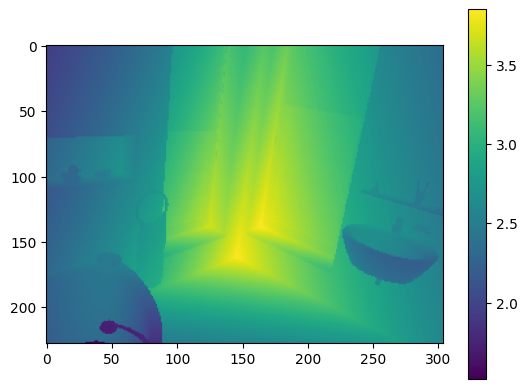

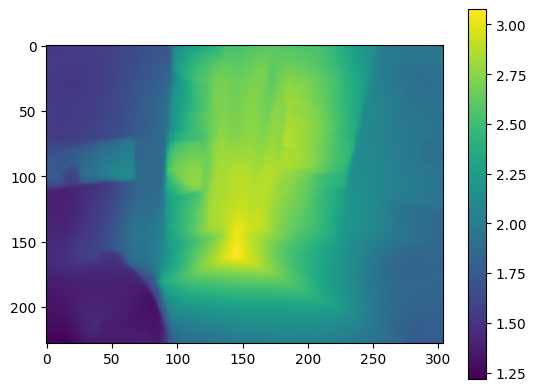

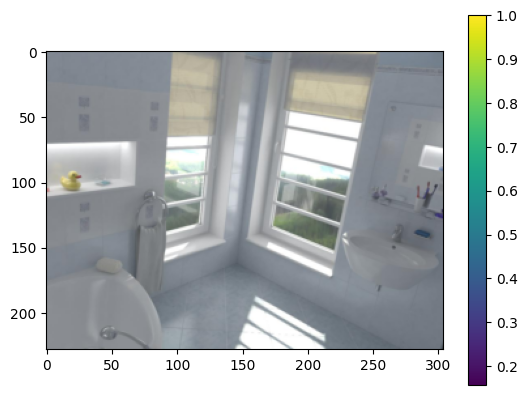

tensor(34, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.1333)
tensor(1.)
tensor(-2.4667)
tensor(2.0671)
tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.)
tensor(1.)
tensor(-3.1068)
tensor(2.0671)
tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.)
tensor(1.)
tensor(-3.1068)
tensor(2.0671)
tensor(1, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.0039)
tensor(1.)
tensor(-2.9186)
tensor(2.0671)
tensor(1, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.0039)
tensor(1.)
tensor(-2.8433)
tensor(2.0671)
5


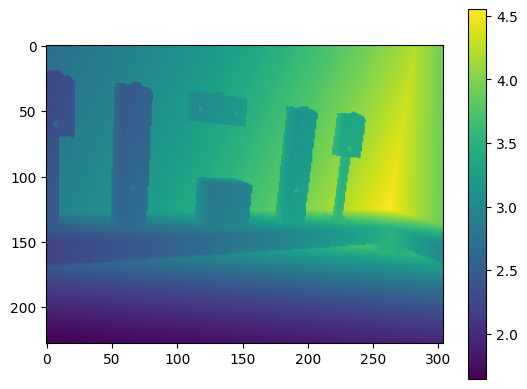

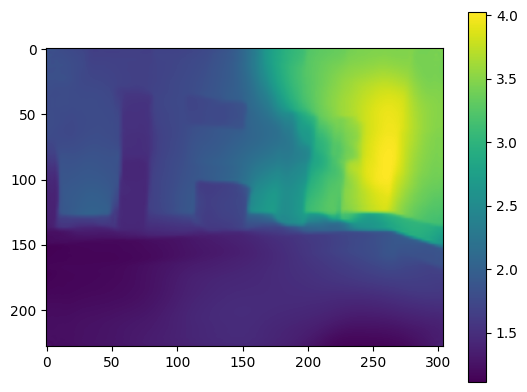

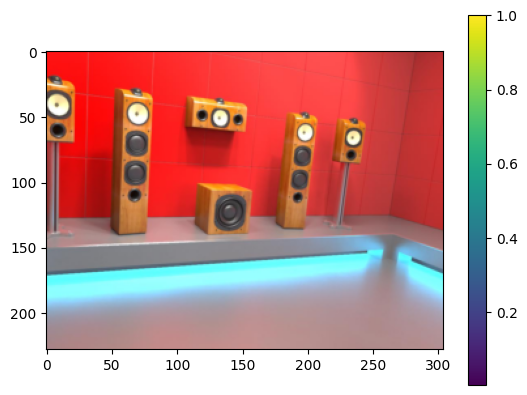

tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.)
tensor(1.)
tensor(-2.8997)
tensor(2.0671)
tensor(3, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.0118)
tensor(1.)
tensor(-2.8244)
tensor(2.0671)
tensor(13, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.0510)
tensor(1.)
tensor(-2.8621)
tensor(2.0671)
tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.)
tensor(1.)
tensor(-3.1068)
tensor(2.0671)
tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.)
tensor(1.)
tensor(-3.1068)
tensor(2.0671)
10


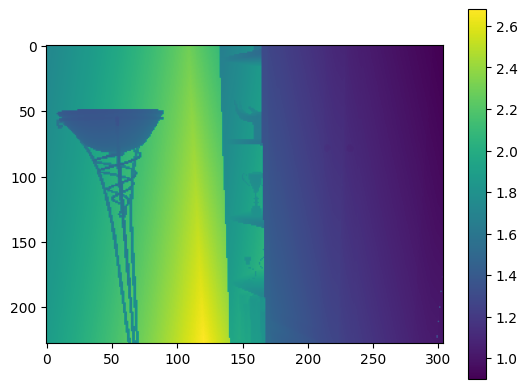

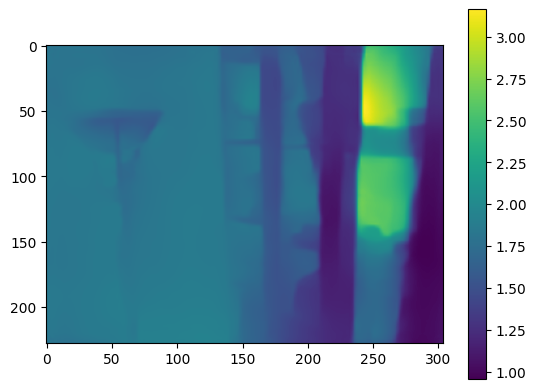

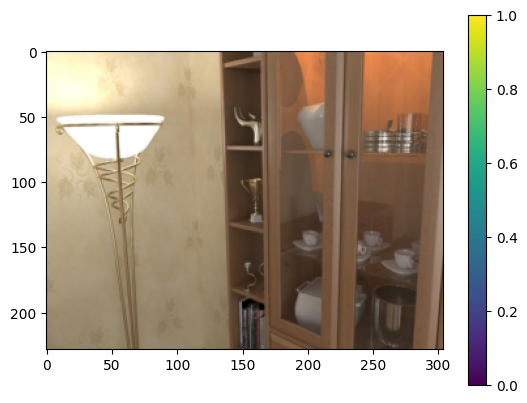

tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.)
tensor(1.)
tensor(-2.6738)
tensor(2.0671)
tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.)
tensor(1.)
tensor(-1.9946)
tensor(2.0671)
tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.)
tensor(1.)
tensor(-2.8056)
tensor(2.0671)
tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.)
tensor(1.)
tensor(-2.2973)
tensor(2.0671)
tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.)
tensor(1.)
tensor(-2.3538)
tensor(2.0671)
15


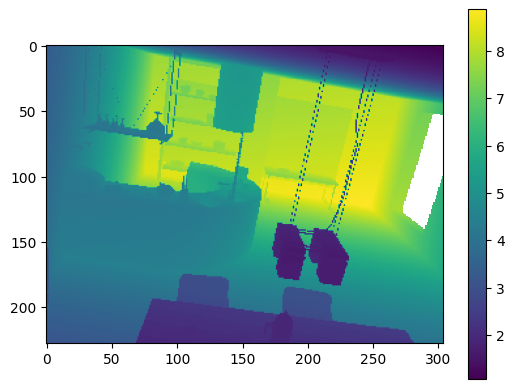

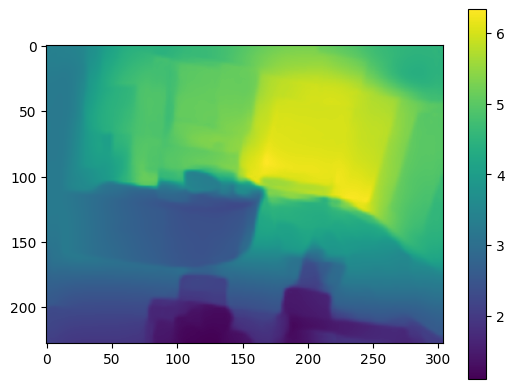

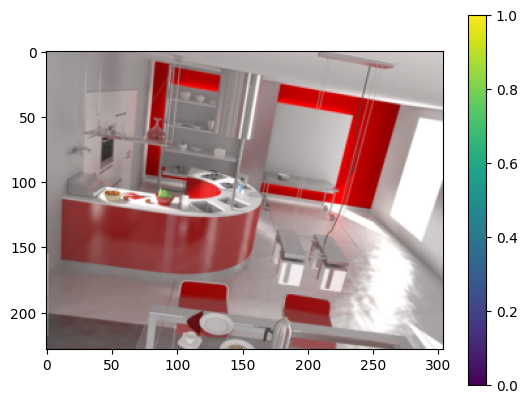

In [44]:
for i, sample_batched in enumerate(test_loader):
    if(i%5==0):
        print(i)
        display_tensor_data(sample_batched["depth"][0,:].detach())
        display_tensor_data(depth_results[i][0,:].detach())
        display_tensor_data(sample_batched["image"][0,:].detach(), denormalize)

tensor(40, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.1569)
tensor(1.)
tensor(-2.3538)
tensor(2.0671)
0
Depth max:  tensor(3.0770)
Depth min:  tensor(1.2185)
Depth groundtruth max:  tensor(3.8483)
Depth groundtruth min:  tensor(1.5194)
Error max:  tensor(1.6258)
Error min:  tensor(0.)


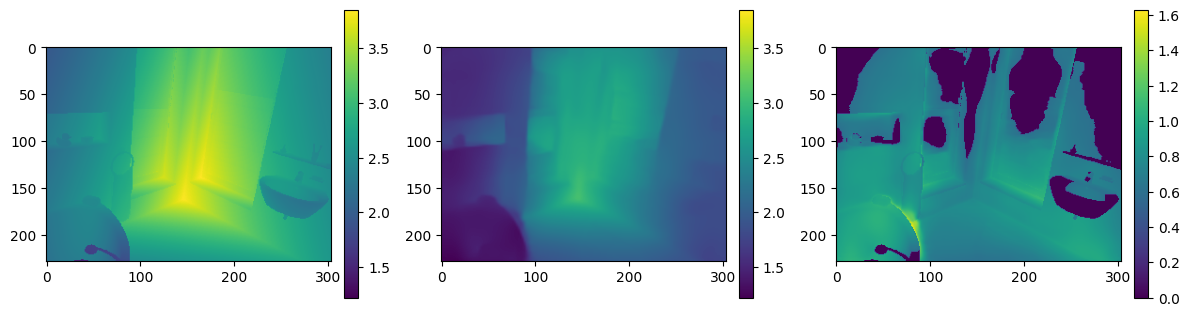

tensor(34, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.1333)
tensor(1.)
tensor(-2.4667)
tensor(2.0671)
tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.)
tensor(1.)
tensor(-3.1068)
tensor(2.0671)
tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.)
tensor(1.)
tensor(-3.1068)
tensor(2.0671)
tensor(1, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.0039)
tensor(1.)
tensor(-2.9186)
tensor(2.0671)
tensor(1, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.0039)
tensor(1.)
tensor(-2.8433)
tensor(2.0671)
5
Depth max:  tensor(4.0240)
Depth min:  tensor(1.1123)
Depth groundtruth max:  tensor(4.5503)
Depth groundtruth min:  tensor(1.6467)
Error max:  tensor(1.8848)
Error min:  tensor(0.)


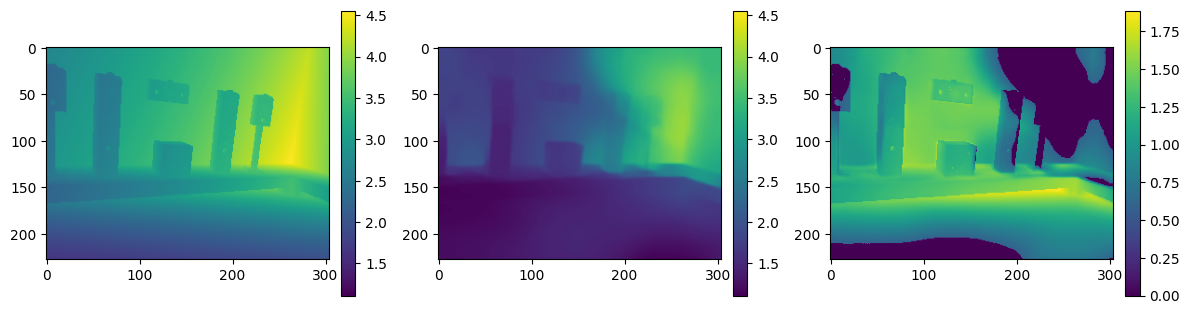

tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.)
tensor(1.)
tensor(-2.8997)
tensor(2.0671)
tensor(3, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.0118)
tensor(1.)
tensor(-2.8244)
tensor(2.0671)
tensor(13, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.0510)
tensor(1.)
tensor(-2.8621)
tensor(2.0671)
tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.)
tensor(1.)
tensor(-3.1068)
tensor(2.0671)
tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.)
tensor(1.)
tensor(-3.1068)
tensor(2.0671)
10
Depth max:  tensor(3.1642)
Depth min:  tensor(0.9565)
Depth groundtruth max:  tensor(2.6794)
Depth groundtruth min:  tensor(0.9008)
Error max:  tensor(2.0947)
Error min:  tensor(0.)


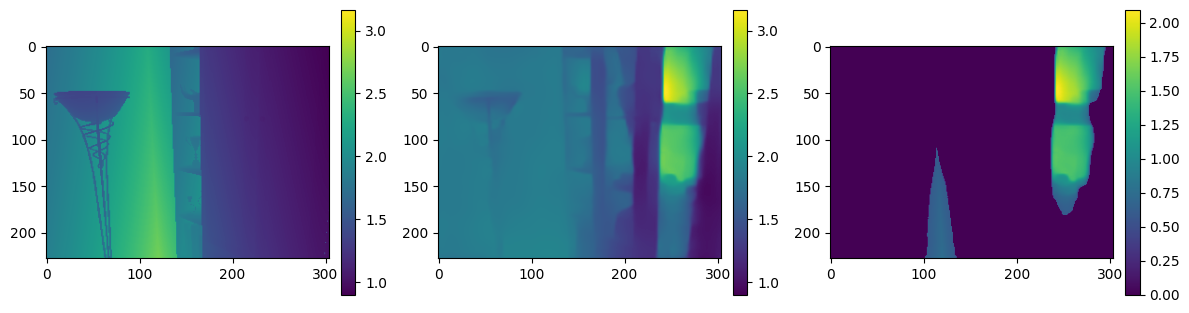

tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.)
tensor(1.)
tensor(-2.6738)
tensor(2.0671)
tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.)
tensor(1.)
tensor(-1.9946)
tensor(2.0671)
tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.)
tensor(1.)
tensor(-2.8056)
tensor(2.0671)
tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.)
tensor(1.)
tensor(-2.2973)
tensor(2.0671)
tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.)
tensor(1.)
tensor(-2.3538)
tensor(2.0671)
15
Depth max:  tensor(6.3323)
Depth min:  tensor(1.1095)
Depth groundtruth max:  tensor(nan)
Depth groundtruth min:  tensor(nan)
Error max:  tensor(nan)
Error min:  tensor(nan)
Min_Scale:  tensor(1.0709)
Max_Scale:  tensor(8.8757)


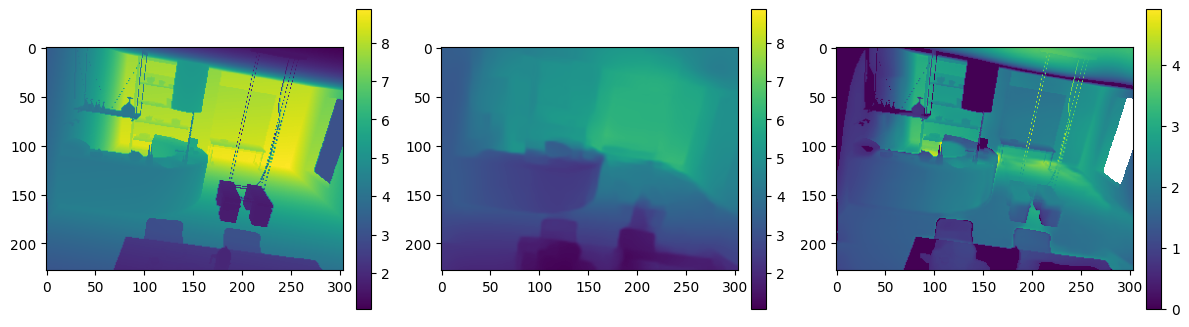

In [135]:
for i, sample_batched in enumerate(test_loader):
    if(i%5==0):
        print(i)
        display_image_triplets(sample_batched["depth"][0,:].detach(), depth_results[i][0,:].detach())

tensor(40, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.1569)
tensor(1.)
tensor(-2.3538)
tensor(2.0671)
0
Depth max:  tensor(3.0770)
Depth min:  tensor(1.2185)
Depth groundtruth max:  tensor(3.8483)
Depth groundtruth min:  tensor(1.5194)
Error max:  tensor(1.6258)
Error min:  tensor(0.)


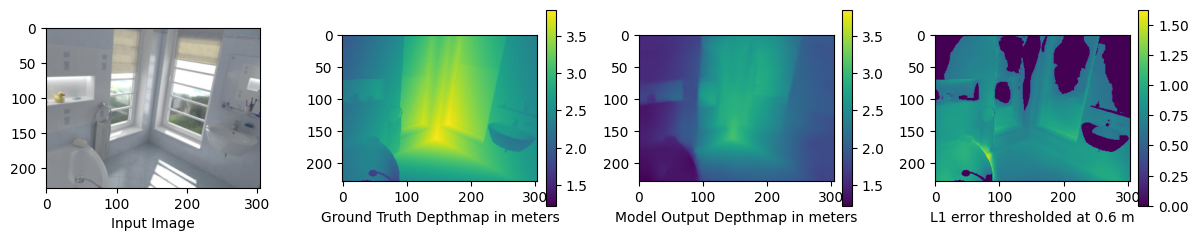

tensor(34, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.1333)
tensor(1.)
tensor(-2.4667)
tensor(2.0671)
tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.)
tensor(1.)
tensor(-3.1068)
tensor(2.0671)
tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.)
tensor(1.)
tensor(-3.1068)
tensor(2.0671)
tensor(1, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.0039)
tensor(1.)
tensor(-2.9186)
tensor(2.0671)
tensor(1, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.0039)
tensor(1.)
tensor(-2.8433)
tensor(2.0671)
5
Depth max:  tensor(4.0240)
Depth min:  tensor(1.1123)
Depth groundtruth max:  tensor(4.5503)
Depth groundtruth min:  tensor(1.6467)
Error max:  tensor(1.8848)
Error min:  tensor(0.)


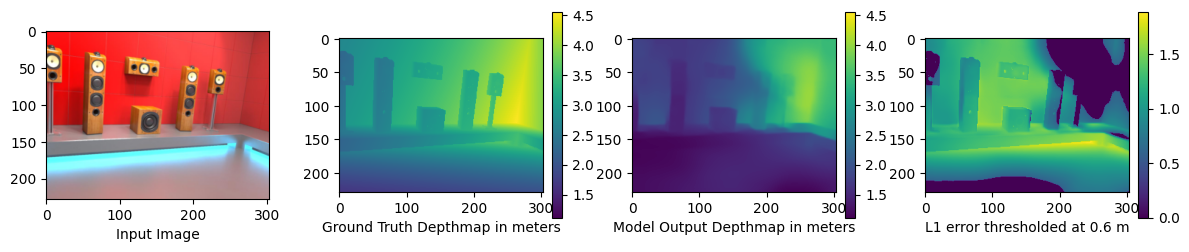

tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.)
tensor(1.)
tensor(-2.8997)
tensor(2.0671)
tensor(3, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.0118)
tensor(1.)
tensor(-2.8244)
tensor(2.0671)
tensor(13, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.0510)
tensor(1.)
tensor(-2.8621)
tensor(2.0671)
tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.)
tensor(1.)
tensor(-3.1068)
tensor(2.0671)
tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.)
tensor(1.)
tensor(-3.1068)
tensor(2.0671)
10
Depth max:  tensor(3.1642)
Depth min:  tensor(0.9565)
Depth groundtruth max:  tensor(2.6794)
Depth groundtruth min:  tensor(0.9008)
Error max:  tensor(2.0947)
Error min:  tensor(0.)


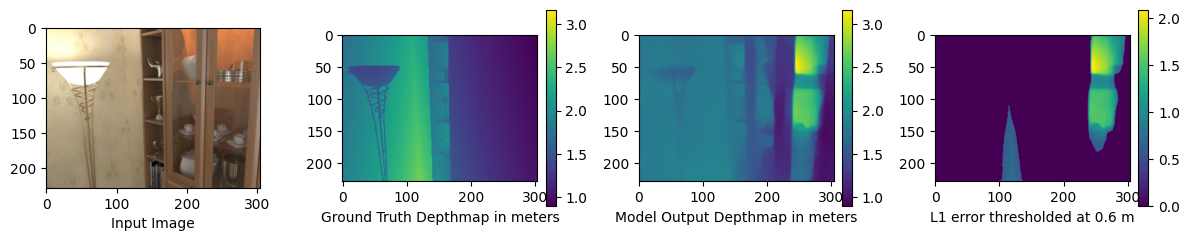

tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.)
tensor(1.)
tensor(-2.6738)
tensor(2.0671)
tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.)
tensor(1.)
tensor(-1.9946)
tensor(2.0671)
tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.)
tensor(1.)
tensor(-2.8056)
tensor(2.0671)
tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.)
tensor(1.)
tensor(-2.2973)
tensor(2.0671)
tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0.)
tensor(1.)
tensor(-2.3538)
tensor(2.0671)
15
Depth max:  tensor(6.3323)
Depth min:  tensor(1.1095)
Depth groundtruth max:  tensor(nan)
Depth groundtruth min:  tensor(nan)
Error max:  tensor(nan)
Error min:  tensor(nan)
Min_Scale:  tensor(1.0709)
Max_Scale:  tensor(8.8757)


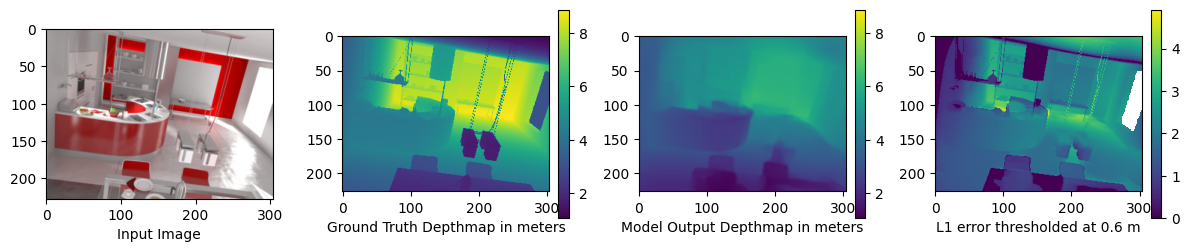

In [156]:
for i, sample_batched in enumerate(test_loader):
    if(i%5==0):
        print(i)
        plot(sample_batched["depth"][0,:].detach(), depth_results[i][0,:].detach(), denormalize(sample_batched["image"][0,:].detach()), os.path.join("pretrained_error_plots/","plot"+str(i)+".png"))

In [ ]:
depth_edge = edge_detection(depth_results[0]) #additional dimension due to batch 
display_tensor_data(depth_edge.detach())

thre = 0.25
edge_valid = (depth_edge > thre)
display_tensor_data(edge_valid)